In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import Counter
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

In [2]:
def plot_bar_percentages(ax, include_values=False, label_type='edge', 
                         padding=3, **kwargs):
    """
    Add percentage (and optionally absolute value) labels to each bar in a seaborn/matplotlib barplot.

    Parameters
    ----------
    ax : matplotlib Axes
        Axes object containing the bars.
    include_values : bool, default False
        If True, include raw value along with percentage.
    label_type : {'edge', 'center'}
        Position of the label on the bar.
    padding : int, default 3
        Padding between bar and label.
    kwargs : dict
        Additional arguments to pass to bar_label (e.g., fontsize, color).
    """
    # Get all bar containers
    containers = ax.containers

    # Compute total per container for grouped bars
    all_values = []
    for container in containers:
        all_values.extend(container.datavalues)
    grand_total = sum(all_values)

    for container in containers:
        container_total = sum(container.datavalues)

        # Use container_total for relative within group (if needed), or grand_total for overall
        labels = []
        for value in container.datavalues:
            pct = value / grand_total * 100 if grand_total > 0 else 0
            if include_values:
                label = f'{int(value):,} ({pct:.1f}%)'
            else:
                label = f'{pct:.1f}%'
            labels.append(label)

        ax.bar_label(container, labels=labels, label_type=label_type, padding=padding, **kwargs)


In [3]:
def pct_label(pct):
    if round(pct, 1) != int(pct):
        return f"{pct:.1f}%"
    return f"{int(pct)}%"

def pct_adjust(autopcts, color='white', threshold=5, distance=1.4):
    for pct in autopcts:
        pct.set_color(color)
        value = float(pct.get_text().strip('%'))
        if value < threshold:
            pos = pct.get_position()
            pct.set_position(tuple(map(lambda x: x * distance, pos)))

In [4]:
# Load datasets
info = pd.read_csv('species_info.csv')
obs = pd.read_csv('observations.csv')

# Function to display dataset info
def preview_dataset(df, name):
    print(f"{'='*20} Preview: {name} {'='*20}")
    display(df.head())
    print(f"Dataset shape: {df.shape}\n")

# Preview both datasets
preview_dataset(info, 'Species Information')
preview_dataset(obs, 'Observations')

==================== Preview: Species Information ====================


,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


Dataset shape: (5824, 4)

==================== Preview: Observations ====================


,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


Dataset shape: (23296, 3)



# Data Dictionary

## Table: species_info

| Column Name        | Data Type            | Type Detail             | Description                            |
|--------------------|----------------------|-------------------------|----------------------------------------|
| category           | Categorical          | Nominal                 | Species category                       |
| scientific_name    | Categorical          | Nominal                 | Scientific name of species             |
| common_names       | Categorical          | Nominal                 | Common names of species                |
| conservation_status| Categorical (Ordinal)| Ordinal                 | Conservation status of species         |

## Table: observations

| Column Name        | Data Type            | Type Detail             | Description                                                        |
|--------------------|----------------------|-------------------------|--------------------------------------------------------------------|
| scientific_name    | Categorical          | Nominal                 | Scientific name of species                                         |
| park_name          | Categorical          | Nominal                 | Name of the park where the species was observed                    |
| observations       | Integer (Discrete)   | Count                   | Number of times the species was observed in the last 7 days        |


In [5]:
# Rename missing values in conservation_status column
info["conservation_status"] = info["conservation_status"].fillna('Unclassified')
# Add protected status
info['is_protected'] = info.conservation_status != 'Unclassified'
# Prepare data set to be merged
info_mod = info.drop(columns='common_names')
info_mod = info.drop_duplicates()
# Check if all scientific names are unique
info_mod["scientific_name"].value_counts()

scientific_name
Castor canadensis            3
Canis lupus                  3
Hypochaeris radicata         3
Columba livia                3
Puma concolor                3
                            ..
Carex                        1
Hexastylis shuttleworthii    1
Hexastylis heterophylla      1
Hexastylis arifolia          1
Tribulus terrestris          1
Name: count, Length: 5541, dtype: int64

In [6]:
# Kepp last appearance of each species
info_mod = info_mod.drop_duplicates(subset=['scientific_name'], keep='last')
info_mod["scientific_name"].value_counts()

scientific_name
Clethrionomys gapperi gapperi    1
Veronica scutellata              1
Fritillaria atropurpurea         1
Calochortus eurycarpus           1
Verbena stricta                  1
                                ..
Carex projecta                   1
Carex prasina                    1
Carex platyphylla                1
Carex plantaginea                1
Tribulus terrestris              1
Name: count, Length: 5541, dtype: int64

In [7]:
# Create DF with only classified species
classified  =info_mod[ info_mod["conservation_status"] != "Unclassified" ]
classified

,category,scientific_name,common_names,conservation_status,is_protected
7,Mammal,Canis latrans,Coyote,Species of Concern,True
9,Mammal,Canis rufus,Red Wolf,Endangered,True
33,Mammal,Myotis austroriparius,"Mississippi Myotis, Southeastern Myotis",Species of Concern,True
34,Mammal,Myotis grisescens,Gray Myotis,Endangered,True
35,Mammal,Myotis keenii,Keen's Myotis,Species of Concern,True
...,...,...,...,...,...
5302,Vascular Plant,Callitriche marginata,Winged Water-Starwort,Species of Concern,True
5399,Vascular Plant,Camissonia sierrae ssp. alticola,"Mono Hot Springs Evening Primrose, Mono Hot Sp...",Species of Concern,True
5426,Vascular Plant,Epilobium oreganum,"Grants Pass Willowherb, Oregon Fireweed",Species of Concern,True
5436,Vascular Plant,Botrychium ascendens,"Trianglelobe Moonwort, Upswept Moonwort",Species of Concern,True


In [8]:
print(classified["conservation_status"].unique())

['Species of Concern' 'Endangered' 'Threatened' 'In Recovery']


In [9]:
# Create merged df
merge = obs.merge(info_mod, how='left', on='scientific_name')

# Add common_names to merge df
merge['common_names'] = merge.apply(
          lambda row: info_mod[info_mod.scientific_name == row.scientific_name]\
                          ['common_names'].values[0], 
          axis=1)

merge

,scientific_name,park_name,observations,category,common_names,conservation_status,is_protected
0,Vicia benghalensis,Great Smoky Mountains National Park,68,Vascular Plant,"Purple Vetch, Reddish Tufted Vetch",Unclassified,False
1,Neovison vison,Great Smoky Mountains National Park,77,Mammal,American Mink,Unclassified,False
2,Prunus subcordata,Yosemite National Park,138,Vascular Plant,Klamath Plum,Unclassified,False
3,Abutilon theophrasti,Bryce National Park,84,Vascular Plant,Velvetleaf,Unclassified,False
4,Githopsis specularioides,Great Smoky Mountains National Park,85,Vascular Plant,Common Bluecup,Unclassified,False
...,...,...,...,...,...,...,...
23291,Croton monanthogynus,Yosemite National Park,173,Vascular Plant,Prairie Tea,Unclassified,False
23292,Otospermophilus beecheyi,Bryce National Park,130,Mammal,California Ground Squirrel,Unclassified,False
23293,Heterotheca sessiliflora ssp. echioides,Bryce National Park,140,Vascular Plant,Sessileflower False Goldenaster,Unclassified,False
23294,Dicranella rufescens,Yosemite National Park,171,Nonvascular Plant,Dicranella Moss,Unclassified,False


In [10]:
print('Species Categories:', info.category.unique().tolist())
print('Different Species:', info.scientific_name.nunique())
print('Species Conservation Status:', info.conservation_status.unique().tolist())
print('Park Names:', obs.park_name.unique().tolist())

Species Categories: ['Mammal', 'Bird', 'Reptile', 'Amphibian', 'Fish', 'Vascular Plant', 'Nonvascular Plant']
Different Species: 5541
Species Conservation Status: ['Unclassified', 'Species of Concern', 'Endangered', 'Threatened', 'In Recovery']
Park Names: ['Great Smoky Mountains National Park', 'Yosemite National Park', 'Bryce National Park', 'Yellowstone National Park']


## Data Visualization

In [11]:
# Define categories colors for standardization of charts
categories_colors = {k : v for k, v 
in zip(info_mod["category"].value_counts().index, mcolors.TABLEAU_COLORS.keys())} #zip pairs each category with a color name.


# Species per Category

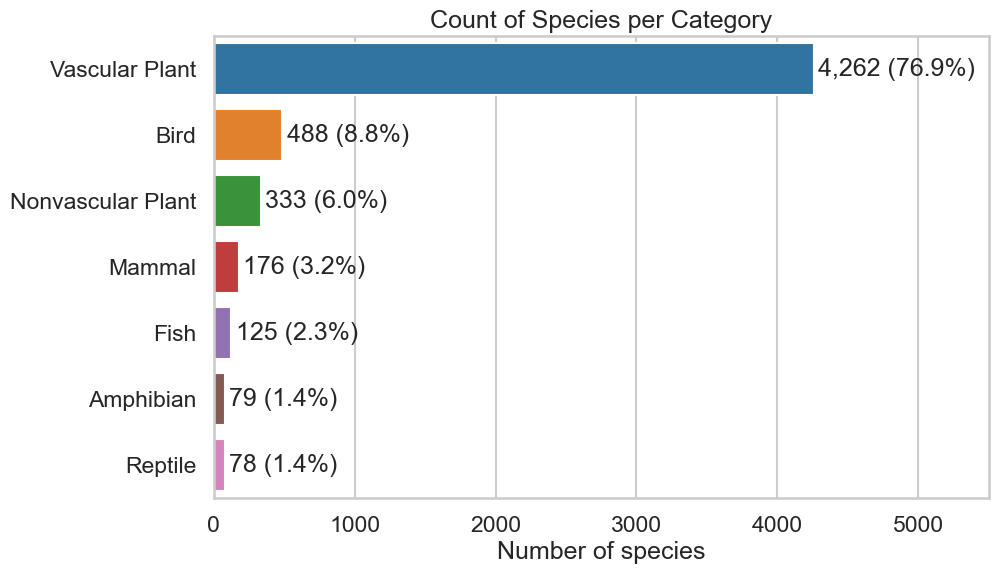

In [12]:
order = info_mod["category"].value_counts().index

fig,ax = plt.subplots(figsize=(10,6))
sns.countplot(data = info_mod ,y='category',hue='category' , legend =False ,ax=ax, order =order,palette =categories_colors )
ax.set_title('Count of Species per Category')
plt.xlim(0, 5500)
#add percentage 
plot_bar_percentages(ax, include_values=True)
ax.set(ylabel='', xlabel='Number of species')
plt.savefig('Species-per-Category.png')
plt.show()

# Conservation Status Distribution 

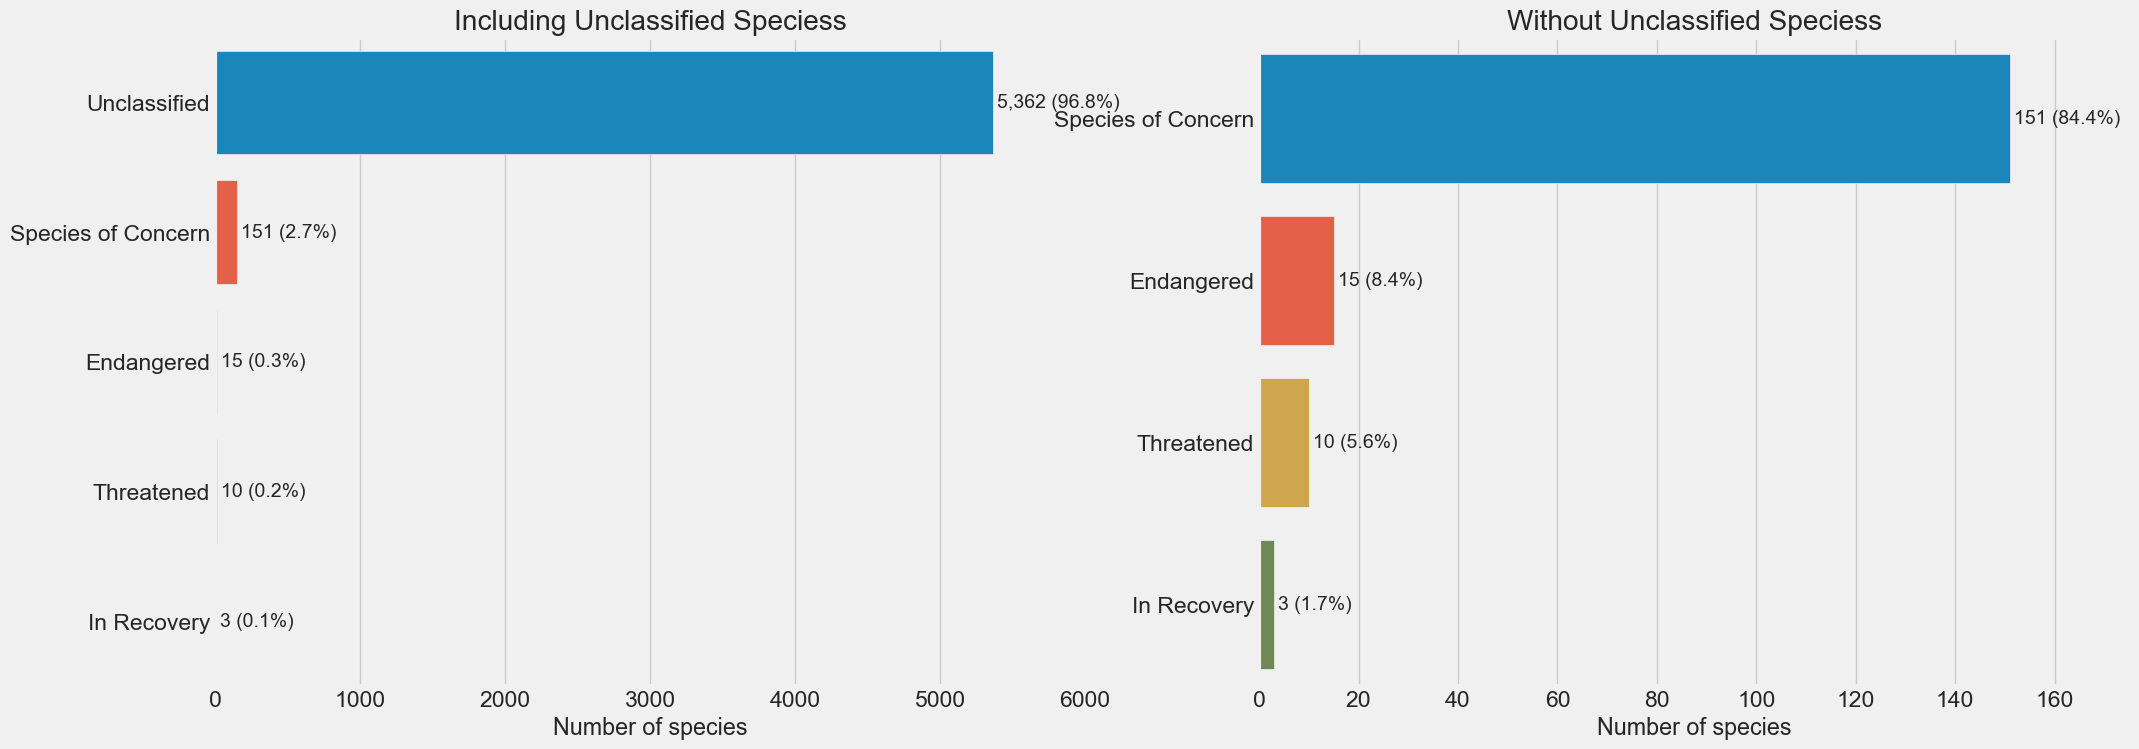

In [39]:
order = info_mod["conservation_status"].value_counts().index
order_2 = classified["conservation_status"].value_counts().index


fig,ax = plt.subplots(1,2,figsize=(22,8))
sns.countplot(data = info_mod ,y='conservation_status',hue='conservation_status' , legend =False ,ax=ax[0], order =order )
ax[0].set_title('Including Unclassified Speciess')
ax[0].set_xlim(0, 6000)
#add percentage 
plot_bar_percentages(ax[0], include_values=True)
ax[0].set(ylabel='', xlabel='Number of species')

#plot without Unclassified species using classified dataframe 

sns.countplot(data = classified ,y='conservation_status',hue='conservation_status' , legend =False ,ax=ax[1], order =order_2 )
ax[1].set_title('Without Unclassified Speciess')
ax[1].set_xlim(0, 175)
#add percentage 
plot_bar_percentages(ax[1], include_values=True)
ax[1].set(ylabel='', xlabel='Number of species')

#adjust space bettwen plot 
plt.subplots_adjust(wspace=0.2)

plt.style.use("fivethirtyeight")

plt.savefig('Conservation-Status-Distribution.png')
plt.show()


In [14]:
print(info_mod["category"].value_counts().index)

Index(['Vascular Plant', 'Bird', 'Nonvascular Plant', 'Mammal', 'Fish',
       'Amphibian', 'Reptile'],
      dtype='object', name='category')


# What is the proportion of protected species per category?

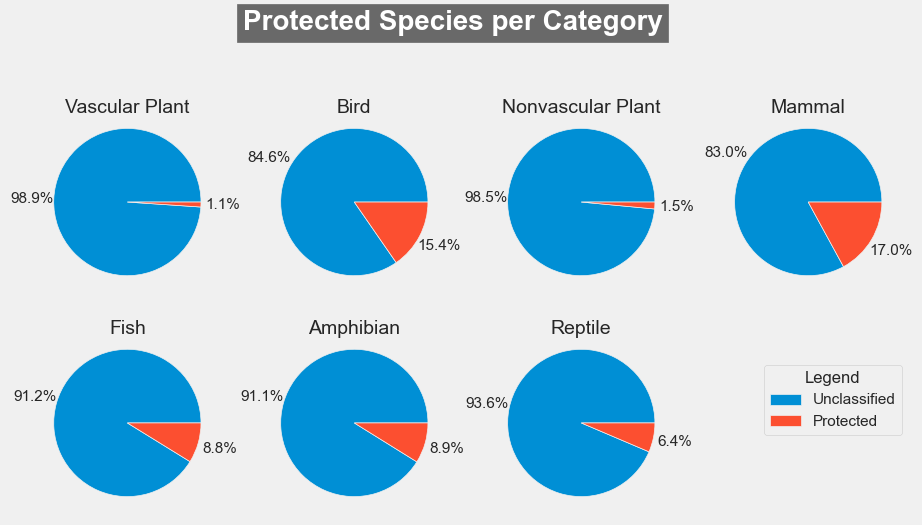

In [15]:
# Create figure and grid
fig = plt.figure(figsize=(10, 5))
fig.suptitle('Protected Species per Category', fontsize=20, 
             fontweight='bold', y=1.08, backgroundcolor='dimgray', color='w')
gs = fig.add_gridspec(2, 4)
# Filter fish DataFrame
for i, category in enumerate(info_mod["category"].value_counts().index, start=0):
    # Plot in first cell
    if i < 4:
        fig.add_subplot(gs[0, i])
    elif i == len(info_mod["category"].value_counts().index):
        fig.add_subplot(gs[1, :])
    else:
        i-=4
        fig.add_subplot(gs[1, i])
    data= info_mod[info_mod["category"] == category]["is_protected"].value_counts()
    plt.title(f'{category}', fontsize=14, y=0.94)
    plt.pie(data, autopct='%.1f%%', pctdistance=1.3 ,textprops = {"fontsize":11})
# Create a legend in the last subplot
legend_labels = ['Unclassified', 'Protected']
fig.legend(title='Legend', labels=legend_labels, loc='center',
           bbox_to_anchor=(0.88, 0.3),
           title_fontsize=12,
           fontsize=11
        )
plt.savefig('Protected-Species-per-Category.png')
plt.show()


# conservation Status of Each Species Category 

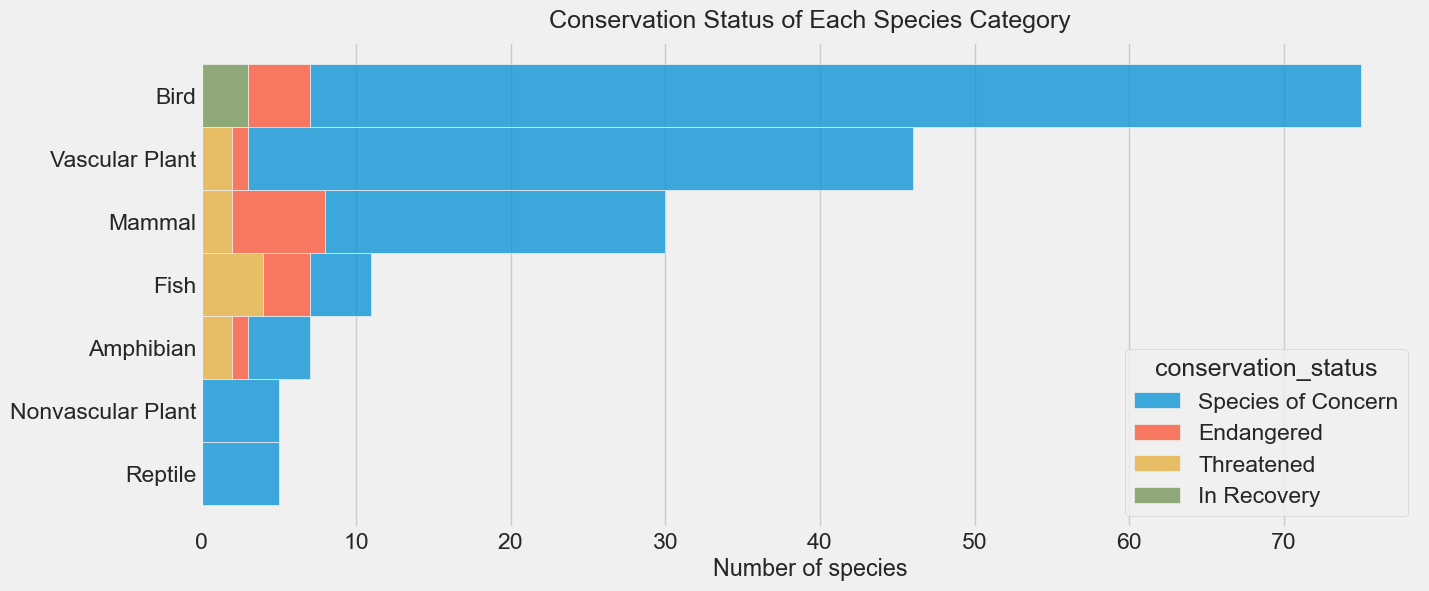

In [40]:
plt.figure(figsize=(14, 6))
# Sort DF by category counts
category_counts = classified['category'].value_counts()
sorted_classified = classified.sort_values(by='category', 
                    key=lambda x: x.map(category_counts), ascending=False)
g = sns.histplot(
    data=sorted_classified,
    y='category',
    hue='conservation_status',
    multiple='stack',
    hue_order=classified["conservation_status"].unique(),  # Optional: to control hue order
      # <<< this sets the y-axis category order
)

g.grid(axis='y')
plt.title('Conservation Status of Each Species Category', fontsize=18, pad=10)
plt.ylabel('')
plt.xlabel('Number of species')
plt.savefig('Conservation-Status-each.png')
plt.show()

# Distribution of categories per conservation status 

In [17]:
statuses = classified[classified["conservation_status"]=="In Recovery"]
statuses

,category,scientific_name,common_names,conservation_status,is_protected
100,Bird,Haliaeetus leucocephalus,Bald Eagle,In Recovery,True
3143,Bird,Falco peregrinus anatum,American Peregrine Falcon,In Recovery,True
4565,Bird,Pelecanus occidentalis,Brown Pelican,In Recovery,True


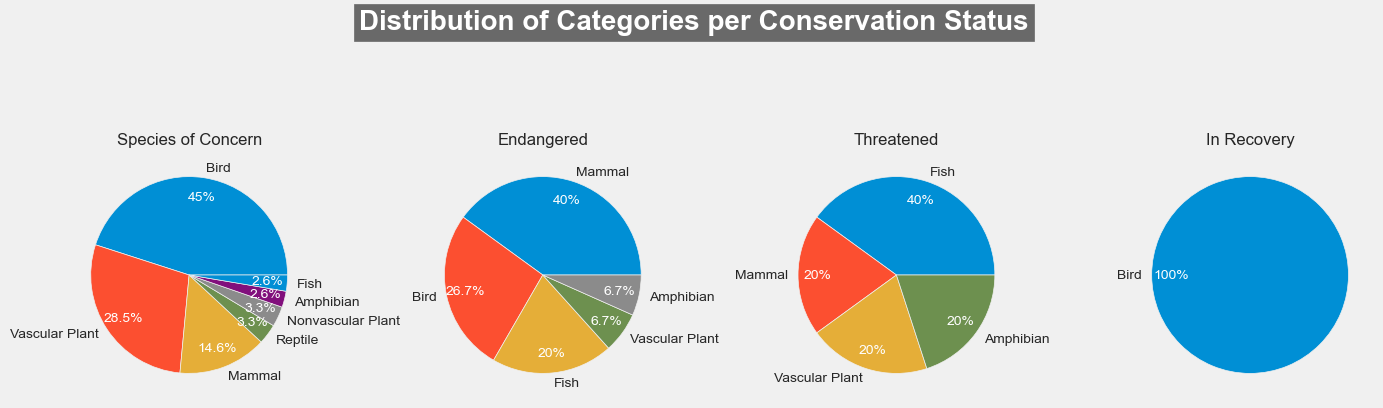

In [43]:
fig = plt.figure(figsize=(14, 7))
fig.suptitle('Distribution of Categories per Conservation Status', fontsize=20, 
             fontweight='bold', y=1.05, backgroundcolor='dimgray', color='w')

gs = fig.add_gridspec(2, 4)
statuses = classified["conservation_status"].value_counts().index

for i, status in enumerate(statuses):
    if i < 4:
        ax = fig.add_subplot(gs[0, i])
    else:
        ax = fig.add_subplot(gs[1, i - 4])

    data = classified[classified["conservation_status"] == status]["category"].value_counts()

    wedges, texts, autotexts = ax.pie(
        data,
        labels=data.index,          # Show category names here
        pctdistance=0.8,
        textprops={"fontsize": 10},
        autopct=lambda pct: pct_label(pct)
    )

    pct_adjust(autotexts, color='white', threshold=5, distance=1)
    ax.set_title(f'{status}', fontsize=12, y=1)
plt.savefig('d-Categories-per-Conservation-Status.png')
plt.tight_layout()
plt.show()

# Observation per Park

In [19]:
obs.head()

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


In [20]:
observation_count = obs.groupby('park_name')["observations"].sum().sort_values(ascending=False)
observation_count

park_name
Yellowstone National Park              1443562
Yosemite National Park                  863332
Bryce National Park                     576025
Great Smoky Mountains National Park     431820
Name: observations, dtype: int64

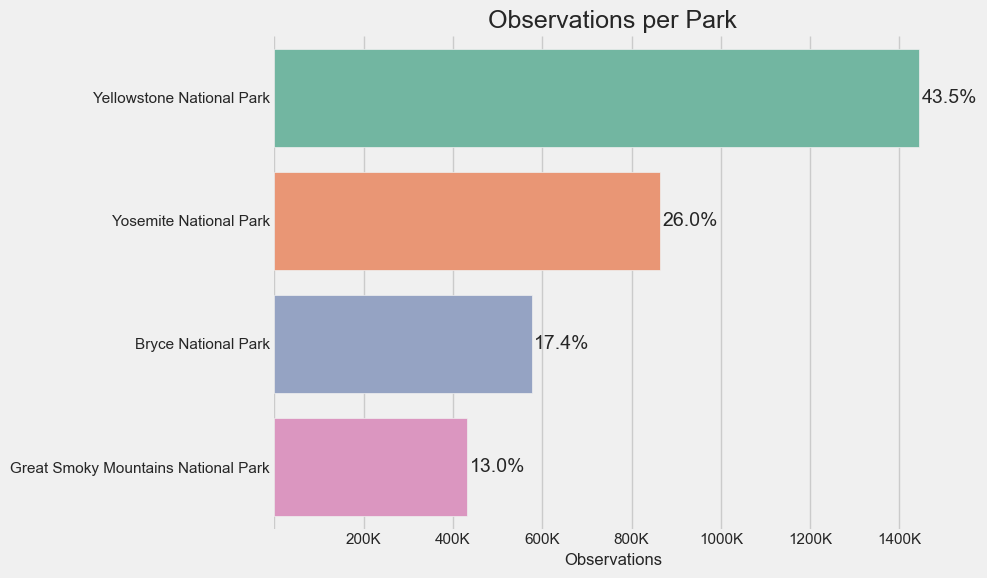

In [21]:

# Create the barplot
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=observation_count.values, y=observation_count.index,hue=observation_count.index,legend=False, ax=ax ,palette="Set2")

# Format x-axis ticks
xticks = range(0, 1500000, 200000)
ax.set_xticks(xticks)
ax.set_xticklabels(
    [f'{x/1000:.0f}K' if x != 0 else '' for x in xticks],
    fontsize=11
)

# Title and labels
ax.set_title('Observations per Park', fontsize=18)
ax.set_ylabel('')
ax.set_xlabel('Observations', fontsize=12)
# Optional: add percentage labels to bars (assuming you have a custom function)
plot_bar_percentages(ax, include_values=False, padding=2)
# Style y-axis ticks
ax.tick_params(axis='y', labelsize=11)

# Remove spines for a cleaner look
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.savefig('Observations-per-Park.png')
plt.show()


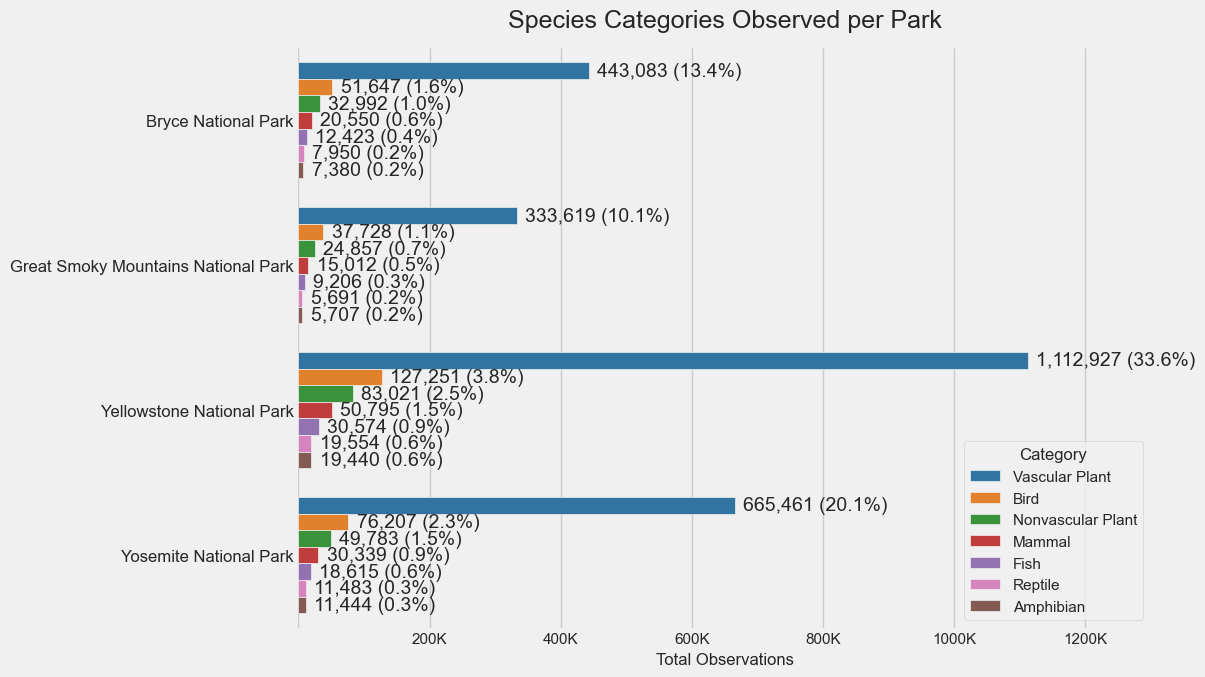

In [22]:
# Sum observations by park and category
park_category = merge.groupby(['park_name', 'category'])['observations'].sum().reset_index()
# Total observations per park for ordering
cat_count = park_category.groupby(['category'])['observations'].sum().sort_values(ascending=False)
# Sort DF by observations count
sorted_park_category = park_category.sort_values(by=['park_name', 'category'], key=lambda col: col.map(cat_count), ascending=False)
# --- Plot ---

fig, ax = plt.subplots(figsize=(12, 7))

sns.barplot(
    data=sorted_park_category,
    x='observations',
    y='park_name',
    hue='category',
    ax=ax,
    palette=categories_colors
)
#Format x-axis ticks
xticks = range(0, 1500000, 200000)
ax.set_xticks(xticks)
ax.set_xticklabels([f'{x/1000:.0f}K' if x != 0 else '' for x in xticks], fontsize=11)
ax.set_xlim(0, 1300000)

# Title and labels
ax.set_title('Species Categories Observed per Park', fontsize=18, pad=15)
ax.set_ylabel('')
ax.set_xlabel('Total Observations', fontsize=12)

# Legend formatting
ax.legend(title='Category', loc='lower right', fontsize=11, title_fontsize=12)

# Y-axis ticks formatting
ax.tick_params(axis='y', labelsize=12)

# Optional: Add percentage or value annotations (assuming your function is defined)
plot_bar_percentages(ax, include_values=True, padding=6)

# Remove spines for a clean look
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.savefig('Species-Categories.png')
plt.show()


# Classified Species Observations per Park'

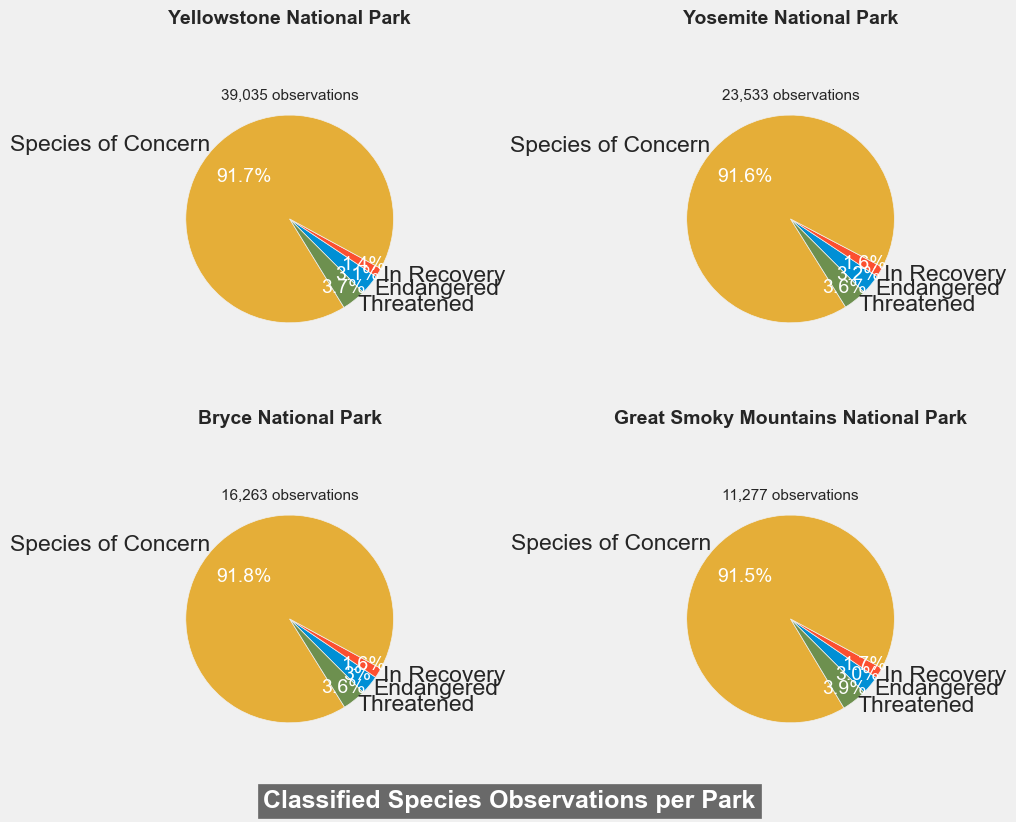

In [47]:
# --- Compute total observations per park ---
observations_count = (
    obs.groupby('park_name')['observations']
    .sum()
    .sort_values(ascending=False)
)

# --- Prepare conservation data ---
park_conservation = (
    merge[merge.conservation_status != 'Unclassified']
    .groupby(['park_name', 'conservation_status'])['observations']
    .sum()
    .reset_index()
)

# --- Change layout: 2 rows x 2 columns ---
fig, axs = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)
fig.suptitle('Classified Species Observations per Park', fontsize=18, fontweight='bold',
             backgroundcolor='dimgray', color='white', y=0.02)

# Flatten axes array for easy iteration
axs = axs.flatten()

# --- Plot each pie chart ---
for ax, park in zip(axs, observations_count.index):
    # Select data
    data = park_conservation[park_conservation.park_name == park]
    
    # Pie chart
    wedges, texts, autotexts = ax.pie(
        data['observations'],
        labels=data['conservation_status'],
        autopct=lambda pct: pct_label(pct),
        startangle=-45,
        labeldistance=1.05
    )
    
    # Adjust percentage labels
    pct_adjust(autotexts, distance=1.4)
    
    # Title and observation count
    total_obs = data['observations'].sum()
    ax.set_title(park, fontsize=14, fontweight='bold', pad=10)
    ax.text(0, 1.15, f'{total_obs:,} observations', fontsize=11, ha='center')
    
    ax.axis('equal')  # keep circular

# Remove unused axes if fewer than 4 parks
for ax in axs[len(observations_count.index):]:
    ax.axis('off')
plt.savefig('Classified-Species-o-park .png')
plt.show()


# Most Common Species per Category

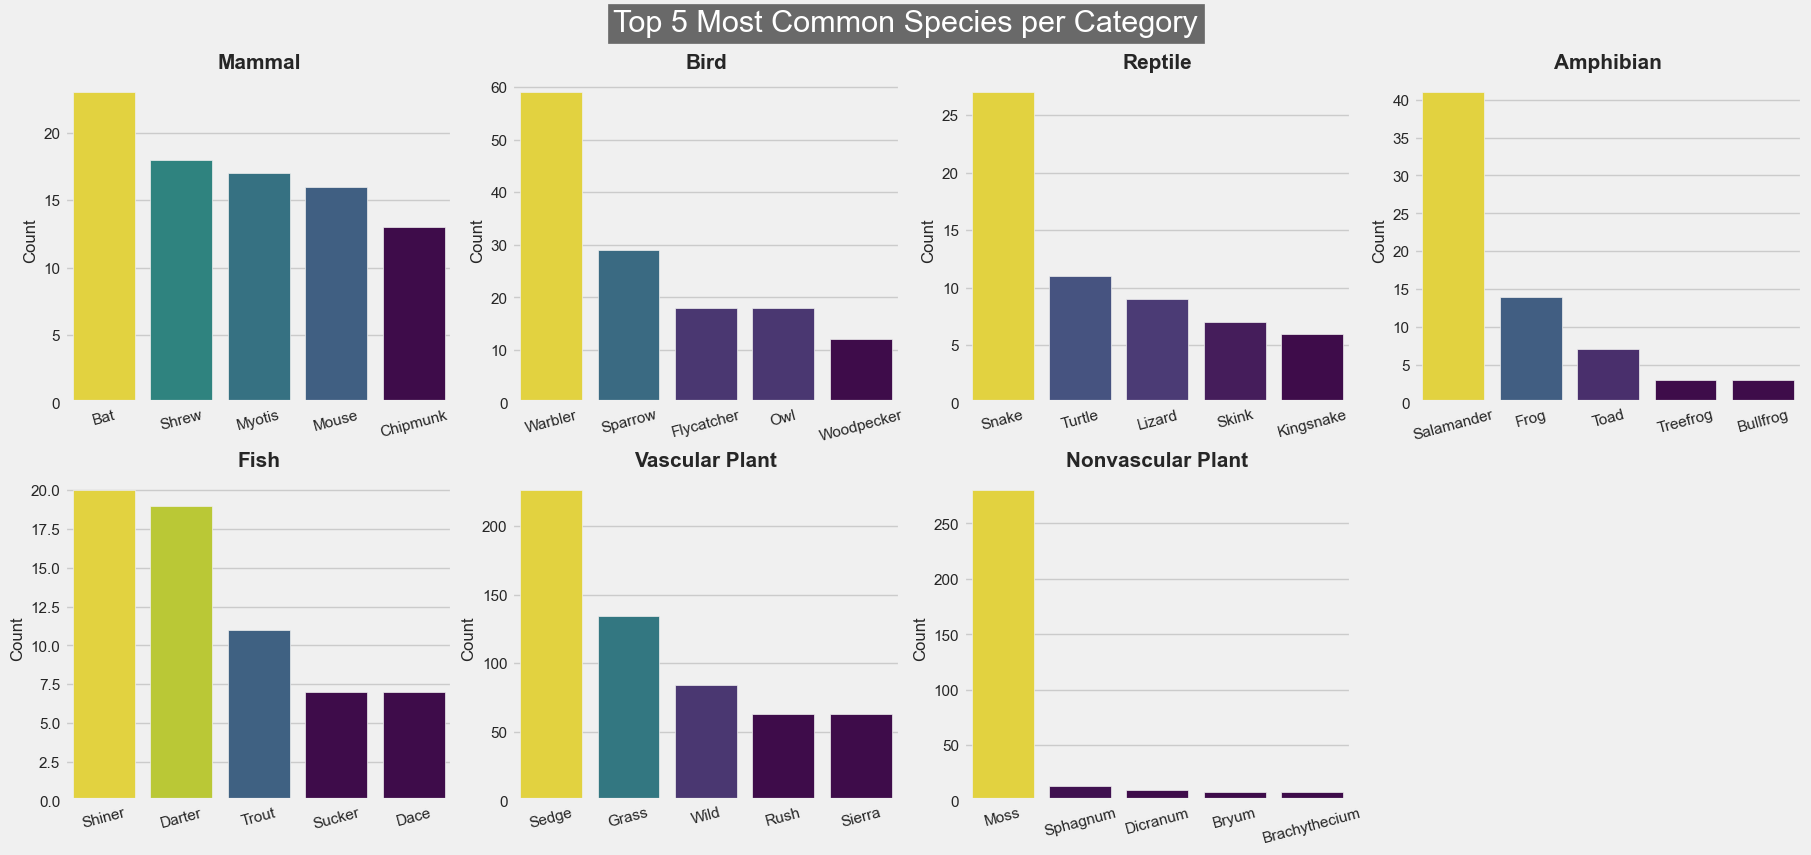

In [24]:


# --- Define stopwords to exclude from common names ---
stopwords = {
    'Common', 'Northern', 'American', 'Eastern', 'Western',
    'California', 'Southern', 'Mountain', 'White', 'Yellow', 'Red',
    'Gray', 'Brown', 'Or', 'Great', 'Black', 'Water', 'Chorus',
    'Mud', 'Spotted', 'Hairy'
}

# --- Count words per category ---
categories_common_names = {}
for category in info['category'].unique():
    words = []
    for name in info.loc[info['category'] == category, 'common_names']:
        cleaned = set(
            name.replace(',', '')
                .replace('(', '')
                .replace(')', '')
                .split()
        )
        filtered = cleaned - stopwords
        words.extend(filtered)
    categories_common_names[category] = Counter(words)

# --- Plot top X common species per category ---
qty = 5

# Setup figure
fig, axs = plt.subplots(2, 4, figsize=(18, 8), constrained_layout=True)
fig.suptitle(f'Top {qty} Most Common Species per Category', fontsize=22,
             backgroundcolor='dimgray', color='white', y=1.05)

# Flatten axes for easy iteration
axs = axs.flatten()

# Plot each bar chart
for ax, (category, counter) in zip(axs, categories_common_names.items()):
    data = counter.most_common(qty)
    species = [item[0] for item in data]
    counts = [item[1] for item in data]
    
    sns.barplot(x=species, y=counts,hue=counts,legend=False, ax=ax, palette='viridis')
    ax.set_title(category, fontsize=15, fontweight='bold')
    ax.set_ylabel('Count', fontsize=12)
    ax.tick_params(axis='x', labelsize=11, rotation=15)
    ax.tick_params(axis='y', labelsize=11)

# Remove unused axes if any
for ax in axs[len(categories_common_names):]:
    ax.remove()
plt.savefig('Most-Common-perCategory.png')
plt.show()


# Most Common Species Observed per Park

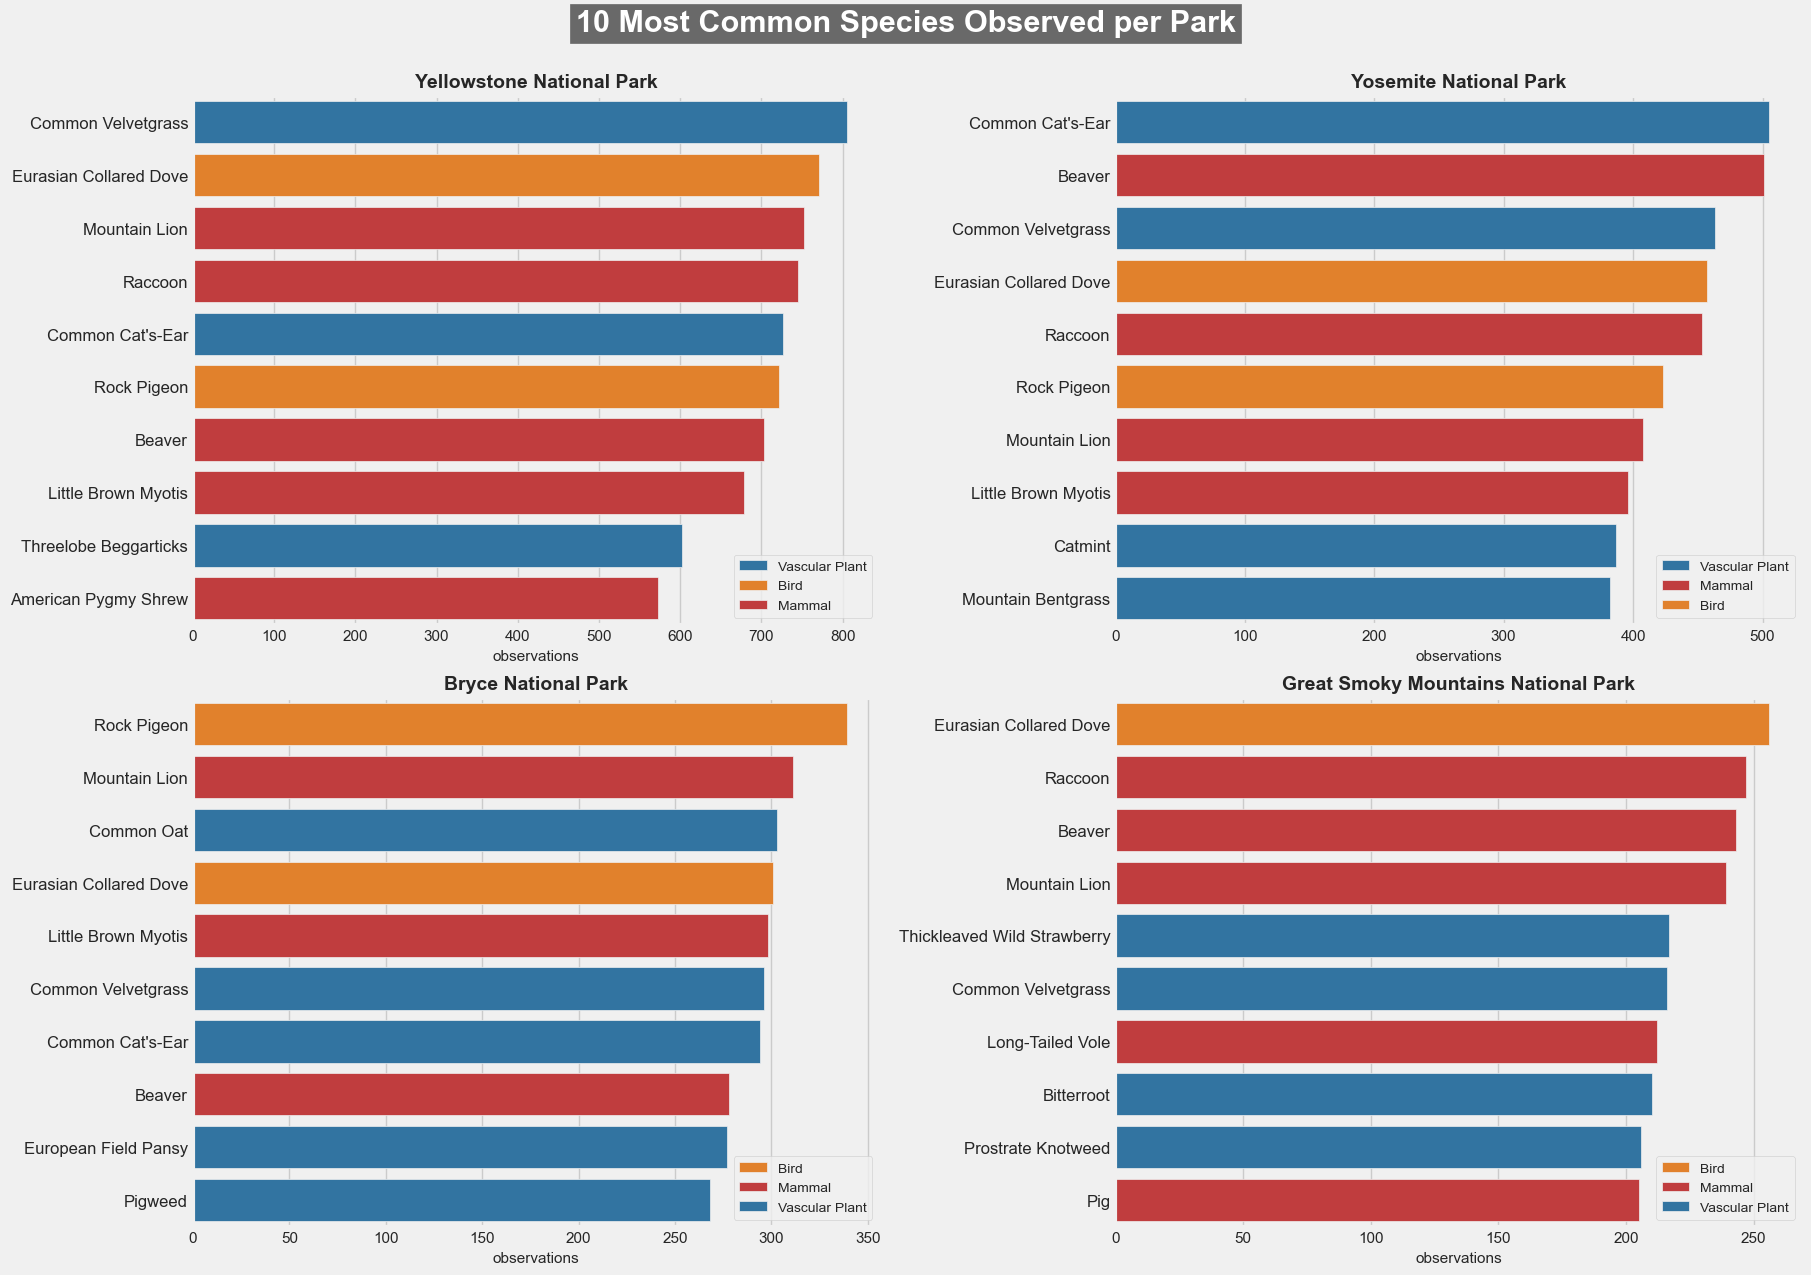

In [25]:
# Plot k most common species observed per park
k = 10

fig, axs = plt.subplots(2, 2, figsize=(18, 12), layout='constrained')
fig.suptitle(f'{k} Most Common Species Observed per Park', fontsize=22, fontweight='bold', backgroundcolor='dimgrey', color='w', y=1.05)

for i, park in enumerate(observations_count.index, start=1):
    # Prepare data to be plotted
    obs_count = merge[(merge.park_name == park)]\
        .groupby(['scientific_name', 'category'])['observations'].sum().sort_values(ascending=False).reset_index()[:k]

    obs_count['common_name'] = obs_count.apply(lambda row: merge[merge.scientific_name == row.scientific_name]['common_names'].values[0].split(',')[0], axis=1)

    # Prepare Axes
    plt.subplot(2, 2, i)
    plt.title(f'{park}', fontsize=14, fontweight='bold')
    
    # Draw Chart
    g = sns.barplot(data=obs_count, y='common_name', x='observations', hue='category', dodge=False, palette=categories_colors)
    plt.ylabel('')
    plt.xlabel(g.get_xlabel(), fontsize=11)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=11)
    g.legend(loc='lower right',fontsize=10)

plt.savefig('Most-Common-species-ob-perpark.png')